### Logistic Regression and AdaBoost

Group 4: Kiet Ly, Mary Monroe, and Shaswati Mukherjee

The code below steps through loading the data, splitting it into test/train datasets, tuning parameters and 

First we import libraries.

In [124]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

Next, we load the data. 

In [159]:
#import data
tweets1 = pd.read_csv('tweets_nlp_1_2.csv')
tweets2 = pd.read_csv('tweets_nlp_2_2.csv')
tweets3 = pd.read_csv('tweets_nlp_3_2.csv')
all_tweets = pd.concat([tweets1, tweets2, tweets3], sort=False)

Next we filter down to only the features we want to keep. Since we are going to compare the accuracy of our models between a base set of features and an extended set with nlp features, we can filter first for the extended set

In [201]:
all_tweets_df_nlp2 = all_tweets[['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions',\
                                 'user_type', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',\
                                 'token_count', 'url_token_ratio', 'ratio_neg', \
                                 'ant', 'fear', 'joy', 'trust','jaccard']]

Now we standardize columns in our dataset

In [202]:
def standardize(df, col_list):
    for column in col_list:
        min_x = df[column].min()
        max_x = df[column].max()
        rangex = max_x - min_x
        df.loc[:, column]= df.loc[:,column].apply(lambda x: (x-min_x)/rangex)     
    return(df)

col_list = ['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions','url_token_ratio', 'jaccard', 'token_count']
all_tweets_df_nlp = standardize(all_tweets_df_nlp2, col_list)
all_tweets_df = all_tweets_df_nlp[['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions','user_type']]

In [204]:
all_tweets_df_nlp.describe()

,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,user_type,sentiment_negative,sentiment_neutral,sentiment_positive,token_count,url_token_ratio,ratio_neg,ant,fear,joy,trust,jaccard
count,120260.000000,120260.000000,120260.000000,120260.000000,120260.000000,120260.000000,120260.000000,120260.000000,120260.000000,120260.000000,120260.000000,120260.000000,120260.000000,120260.000000,120260.000000,120260.000000,120260.000000
mean,0.000096,0.002141,0.007242,0.122886,0.027090,0.409729,0.109953,0.483719,0.406328,0.518684,0.011865,0.109953,0.195784,0.108324,0.161217,0.199410,0.020638
std,0.005292,0.013521,0.022699,0.129295,0.051426,0.491786,0.312833,0.499737,0.491149,0.240949,0.015402,0.060860,0.396805,0.310790,0.367733,0.399558,0.045951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.079268,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503145,0.000000,0.105263,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.250000,0.058824,1.000000,0.000000,1.000000,1.000000,0.735849,0.020833,0.149588,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Split our data into train/test for the base and extended feature dataset.

In [208]:
def train_test_split_nlp(basedf, nlpdf):
    splits = {}
    i=0
    for df in [basedf, nlpdf]:
        train_df, test_df = train_test_split(df, test_size=0.33, random_state=42, stratify=df['user_type'])
        ytrain_df = train_df['user_type']
        xtrain_df = train_df.drop('user_type', axis = 1)
        ytest_df = test_df['user_type']
        xtest_df = test_df.drop('user_type', axis = 1)
        if i == 0:
            splits['base'] = (xtrain_df, ytrain_df, xtest_df, ytest_df)
            i+=1
        else:
            splits['nlp'] = (xtrain_df, ytrain_df, xtest_df, ytest_df)
    return splits


splits = train_test_split_nlp(all_tweets_df, all_tweets_df_nlp)

xtrain_base, ytrain_base, xtest_base, ytest_base = splits['base'][0], splits['base'][1], splits['base'][2],splits['base'][3]
xtrain_nlp, ytrain_nlp, xtest_nlp, ytest_nlp = splits['nlp'][0], splits['nlp'][1], splits['nlp'][2], splits['nlp'][3] 


Next we compared accuracy of a Logistic Regression Classifier (LR) when using the base vs extended features. The accuracy of the LR improved by 6% when NLP features were used in addition to the base features. LR with base features achieved a test accuracy of 74% while the LR with NLP features scored 82%.

In [206]:
model_log_cv_base = LogisticRegressionCV(cv = 5).fit(xtrain_base, ytrain_base)

train_score_logcv_base = model_log_cv_base.score(xtrain_base, ytrain_base)
test_score_logcv_base = model_log_cv_base.score(xtest_base, ytest_base)
print("Log Regression Model Accuracy with Base Features (Train) is ",train_score_logcv_base)
print("Log Regression Model Accuracy with Base Features (Test) is ",test_score_logcv_base)

Log Regression Model Accuracy with Base Features (Train) is  0.7662645518405441
Log Regression Model Accuracy with Base Features (Test) is  0.7640225772312654


In [207]:
model_log_cv = LogisticRegressionCV(cv = 5).fit(xtrain_nlp, ytrain_nlp)

train_score_logcv_nlp = model_log_cv.score(xtrain_nlp, ytrain_nlp)
test_score_logcv_nlp = model_log_cv.score(xtest_nlp, ytest_nlp)
print("Log Regression Model Accuracy with NLP (Train) is ",train_score_logcv_nlp)
print("Log Regression Model Accuracy with NLP (Test) is ",test_score_logcv_nlp)

Log Regression Model Accuracy with NLP (Train) is  0.8250179958795641
Log Regression Model Accuracy with NLP (Test) is  0.8247492818626215


## ADABOOST

Moving on to AdaBoost, we chose model parameters by performing model tuning. The plot below shows accuracy as a function of max depth and estimators. We found that for 100 estimators and a fast learning rate of 0.2, using a max depth of 2 could achieve the same performance if the max depth was 4. We chose the lower cost features for our AdaBoost model: 0.2 learning rate, 100 estimators, max depth 2.

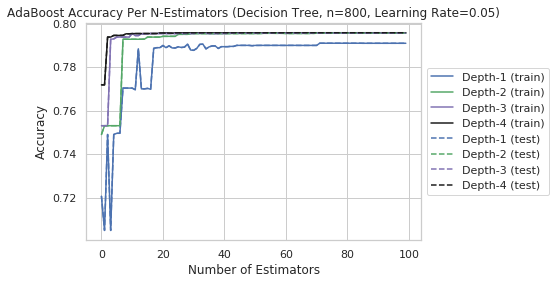

In [210]:
def fitSkAdaBoost(max_depth_list, data_tuple):
    #fits an AdaBoost model for each depth in the max_depth_list
    #returns a list of staged_score generators for each model
    X_train = data_tuple[0]
    y_train = data_tuple[1]
    X_test = data_tuple[0]
    y_test = data_tuple[1]
    score_list_train = []
    score_list_test = []
    #iterate through
    for depth in max_depth_list:
        skadaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth),\
                                        n_estimators=100, learning_rate=0.20)
        skadaboost.fit(X_train, y_train)
        
        #hacky way of saving off stages scores.
        #if I didn't use this way, the variables would only hold the values temporarily
        score_test = skadaboost.staged_score(X_test, y_test)
        scores_test=[]
        for stagesc in score_test:
            scores_test=np.append(scores_test,stagesc)
        score_list_test.append(scores_test)
        
        score_train = skadaboost.staged_score(X_train, y_train)
        scores_train=[]
        for stagesc in score_train:
            scores_train=np.append(scores_train,stagesc)
        score_list_train.append(scores_train)
        
        
    return score_list_train, score_list_test


ss_train, ss_test = fitSkAdaBoost([1,2,3,4], splits['base'])

colors = ['b','g','m','k']
plt.figure()
for i in range(0,4):
    label = 'Depth-'+str(i+1)+' (train)'   
    plt.plot(np.arange(0,100),list(ss_train[i]), color=colors[i], label=label)
for i in range(0,4):
    label = 'Depth-'+str(i+1)+' (test)'   
    plt.plot(np.arange(0,100),list(ss_test[i]), color=colors[i], linestyle='dashed',label=label)
plt.title('AdaBoost Accuracy Per N-Estimators (Decision Tree, n=800, Learning Rate=0.05)')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

We saw a major improvement in accuracy of the AdaBoost models when the NLP features were included. Without NLP features, the model only reached an accuracy of 79%. The model achieved an accuracy of 98% when the NLP features were included.

In [194]:
#modified from lab 9 notes
def adaboost_build_and_plot(data_tuple, max_depth, n_estimators, learning_rate, makeplot=False):
    X_train = data_tuple[0]
    y_train = data_tuple[1]
    X_test = data_tuple[0]
    y_test = data_tuple[1]
   
    skadaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth),
                              n_estimators=n_estimators, learning_rate=learning_rate)
    skadaboost.fit(X_train, y_train)
    print('AdaBoost Accuracy (train)', skadaboost.score(X_train, y_train))
    print('AdaBoost Accuracy (test)', skadaboost.score(X_test, y_test))

    if makeplot == True:
        title = 'AdaBoost Accuracy Per N-Estimators (Decision Tree, Depth-' + str(max_depth) + ', Learning Rate=' + \
                str(learning_rate) + ')'
        staged_scores_test = skadaboost.staged_score(X_test, y_test)
        staged_scores_train = skadaboost.staged_score(X_train, y_train)
        plt.figure()
        plt.plot(np.arange(0,n_estimators),list(staged_scores_test), label='AdaBoost Test', linestyle='dashed', color='r')
        plt.plot(np.arange(0,n_estimators),list(staged_scores_train), label='AdaBoost Train', color='b', alpha = 0.6)
        plt.title(title)
        plt.xlabel('Number of Estimators')
        plt.ylabel('Accuracy')
        plt.legend()

AdaBoost Accuracy (train) 0.7955792191029364
AdaBoost Accuracy (test) 0.7955792191029364
done in 6.109s.


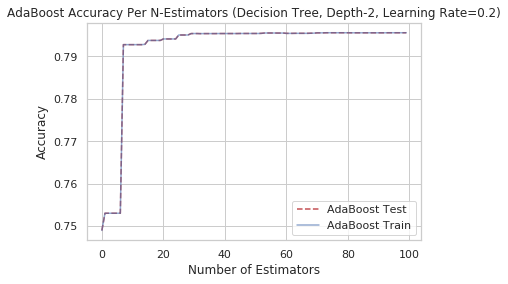

In [195]:
t0 = time()
adaboost_build_and_plot(splits['base'], 2, 100, 0.2, makeplot=True)
print("done in %0.3fs." % (time() - t0))

AdaBoost Accuracy (train) 0.9893017598729119
AdaBoost Accuracy (test) 0.9893017598729119
done in 9.379s.


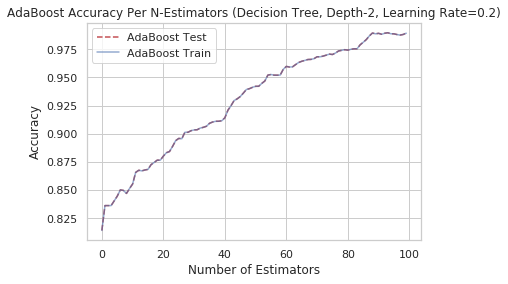

In [211]:
#adaboost_build_and_plot(data_tuple, max_depth, n_estimators, makeplot=False, iterate=False)
t0 = time()
adaboost_build_and_plot(splits['nlp'],2,100,0.2, makeplot=True)
print("done in %0.3fs." % (time() - t0))